In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import minimize
from sklearn.preprocessing import StandardScaler
import xarray as xr
#for MCMC
import pymc as pm
import pymc_extras.distributions as pmx
import arviz as az
from arviz.plots import plot_utils as azpu

# Data preparation

In [2]:
#Prepare data
dat = pd.read_csv("data/cao_index_yearly.csv",sep=";")
GSTM = pd.read_fwf("data/GSTM.txt")
zhou = pd.read_csv("data/Zhou_2024.csv",sep=",")
zhou = zhou.rename(columns={"years": "year"})
zhou = zhou[["year","IPO","AM"]]
dat = dat.merge(GSTM,on='year')
dat = dat.merge(zhou,on='year',how='left')

# Create X and y matrices for regression

In [3]:
#Create X matrix
dat_no_na = dat.dropna()
x1, x2, x3 = dat_no_na[['GSTM','IPO','AM']].T.values
X = np.column_stack((np.ones(len(x1)), x1, x2, x3))
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
#Keep a column of 1's for the intercept
X[:,0] = 1
X_no_intercept = X[:, 1:]

#Two X availables, w/ intercept (X) and no intercept (X_no_interccept)

#Create y matrix
y = dat_no_na["cao_index_max"].values.reshape(-1, 1)

In [4]:
X1 = X_no_intercept[:,0]
X2 = X_no_intercept[:,1]
X3 = X_no_intercept[:,2]
y = y.ravel()

# pymc model


In [5]:
basic_model = pm.Model()

with pm.Model() as basic_model:
    alpha = pm.Normal("alpha",  mu=0,sigma=100)
    beta = pm.Normal("beta", sigma=100,shape=3)
    sigma = pm.HalfNormal("sigma", sigma=1)

    # Expected value of outcome
    mu = alpha +  beta[0] * X1 + beta[1] * X2 +  beta[2] * X3

    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=y)

### Prior predictive check

Sampling: [Y_obs, alpha, beta, sigma]


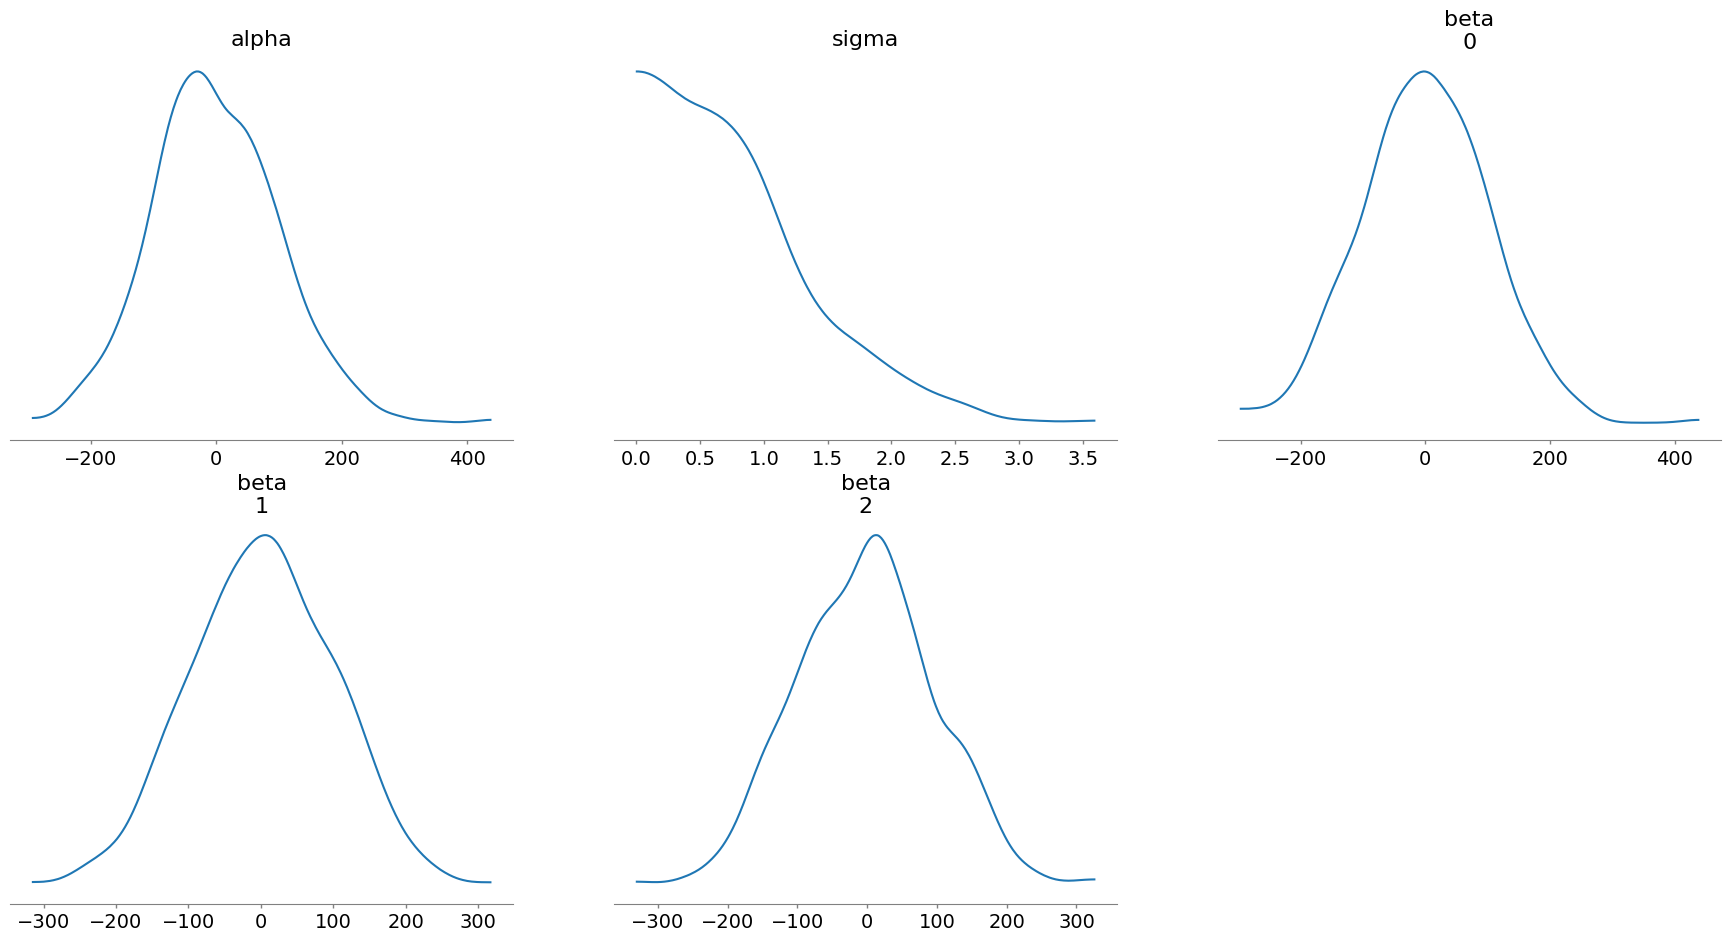

In [6]:
priors_dist = pm.sample_prior_predictive(samples=1000, model=basic_model)
az.plot_posterior(
    priors_dist, group="prior",hdi_prob="hide", point_estimate=None
);

### Run MCMC to sample from posterior

In [7]:
with basic_model:
    # draw 1000 posterior samples
    idata = pm.sample(1000,tune=2000, random_seed=42)

#with model:
#    trace = pm.sample(
#        5000,
#        cores=4,
#        chains=4,
#        tune=2000,
#        target_accept=0.98,
#        progressbar = True
#    )
#idata.extend(trace)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 1 seconds.


### Chain convergence check

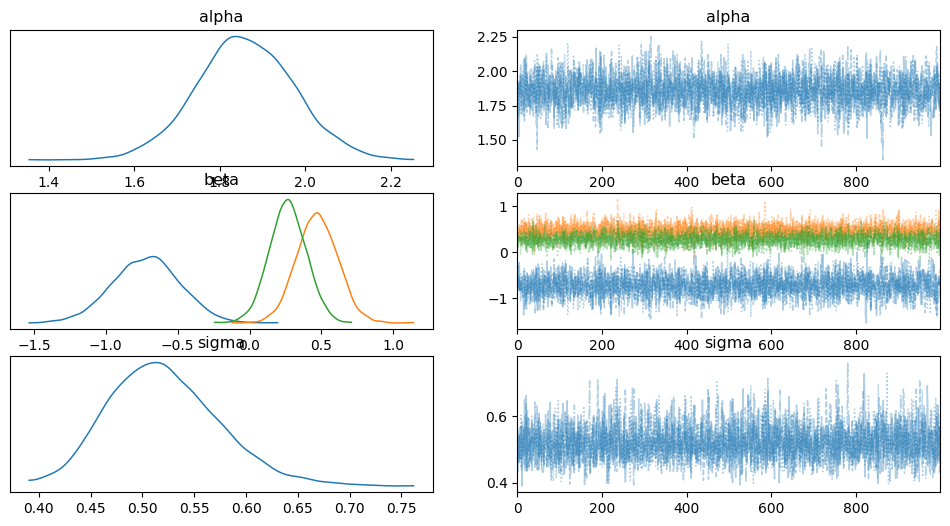

In [8]:
az.plot_trace(idata, combined=True);

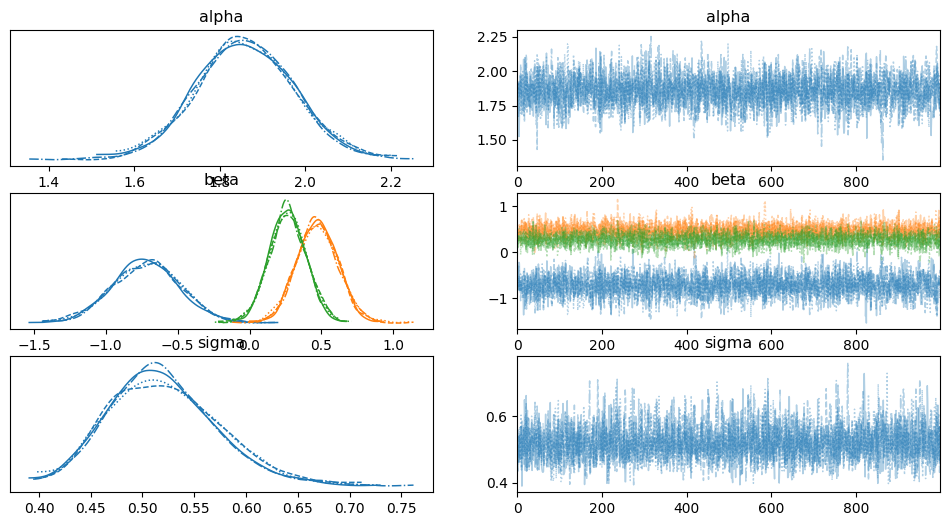

In [9]:
az.plot_trace(idata);

### Summary of posterior

In [10]:
az.summary(idata, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,1.86,0.11,1.65,2.08,0.0,0.0,2984.96,2927.76,1.0
beta[0],-0.72,0.23,-1.15,-0.28,0.0,0.0,2981.64,2892.82,1.0
beta[1],0.47,0.14,0.20,0.73,0.0,0.0,3792.21,2734.87,1.0
beta[2],0.27,0.13,0.04,0.52,0.0,0.0,3736.37,3030.62,1.0
sigma,0.52,0.05,0.43,0.62,0.0,0.0,3126.55,2117.41,1.0


In [11]:
_, vals = az.sel_utils.xarray_to_ndarray(idata["posterior"])

[azpu.calculate_point_estimate("mode", val) for val in vals]

[np.float64(1.8361584870462406),
 np.float64(-0.6704478558950064),
 np.float64(0.4691100003507136),
 np.float64(0.2681106351416009),
 np.float64(0.51336159006997)]

In [12]:
with basic_model:
    pm.sample_posterior_predictive(idata, extend_inferencedata=True)

Sampling: [Y_obs]


Output()

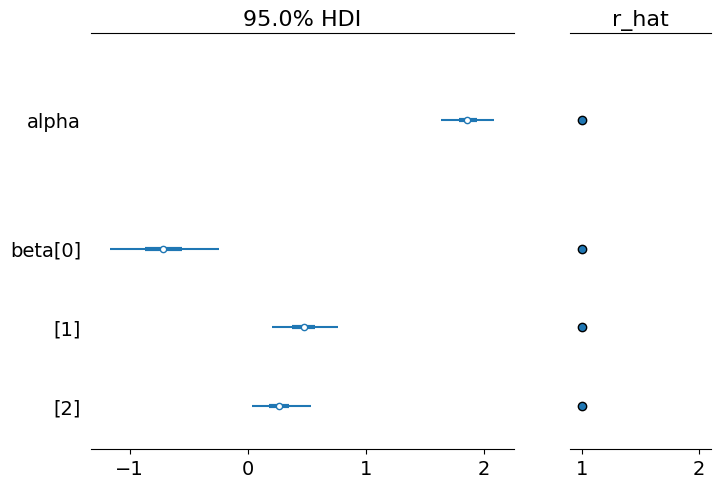

In [13]:
az.plot_forest(idata, var_names=["alpha","beta"], combined=True, hdi_prob=0.95, r_hat=True);

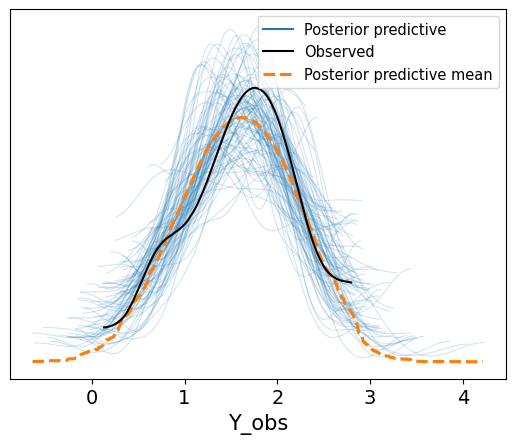

In [14]:
az.plot_ppc(idata, num_pp_samples=100);

# Testing other approach

In [122]:
X = dat_no_na[['GSTM','IPO','AM','cao_index_max']].astype(float)
y = X.pop("cao_index_max")

# Standardize the features
X -= X.mean()
X /= X.std()

N, D = X.shape

In [123]:
import pytensor.tensor as pt

with pm.Model(coords={"predictors": X.columns.values}) as test_model:

    a = pm.Normal("a",mu=0,sigma=100)
    b = pm.Normal("b", sigma=100,dims="predictors")
    sigma = pm.HalfNormal("sigma", sigma=100)

    ll = pm.Normal("obs", a + pt.dot(X.values, b), sigma, observed=y.values)
    idata = pm.sample_prior_predictive(draws=1000)

Sampling: [a, b, obs, sigma]


In [124]:
with test_model:
    prior_samples = pm.sample_prior_predictive(100)

Sampling: [a, b, obs, sigma]


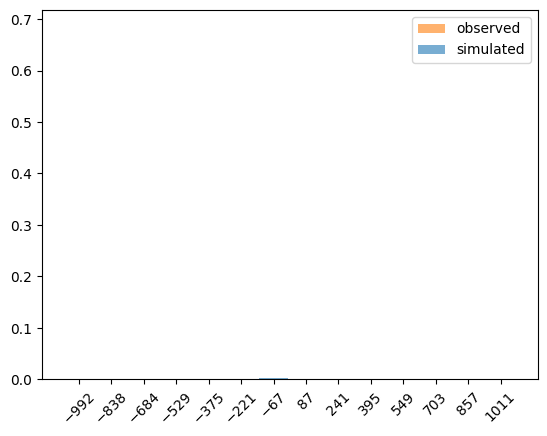

In [125]:
az.plot_dist(
    y.values,
    kind="hist",
    color="C1",
    hist_kwargs={"alpha": 0.6},
    label="observed",
)
az.plot_dist(
    prior_samples.prior_predictive["obs"],
    kind="hist",
    hist_kwargs={"alpha": 0.6},
    label="simulated",
)
plt.xticks(rotation=45);

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 1 seconds.


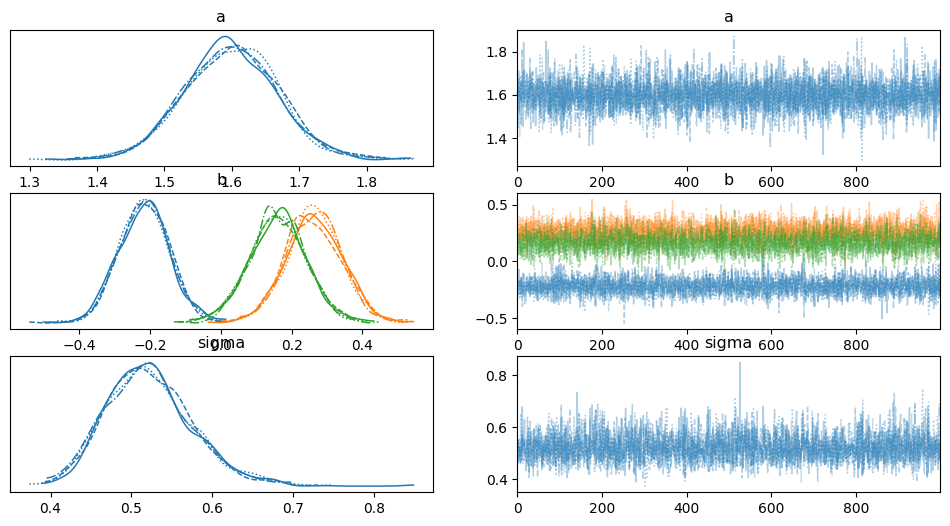

In [126]:
with test_model:
    idata.extend(pm.sample(1000, tune=2000,random_seed=42))

az.plot_trace(idata);

In [127]:
with test_model:
    pm.sample_posterior_predictive(idata, extend_inferencedata=True)

Sampling: [obs]


Output()

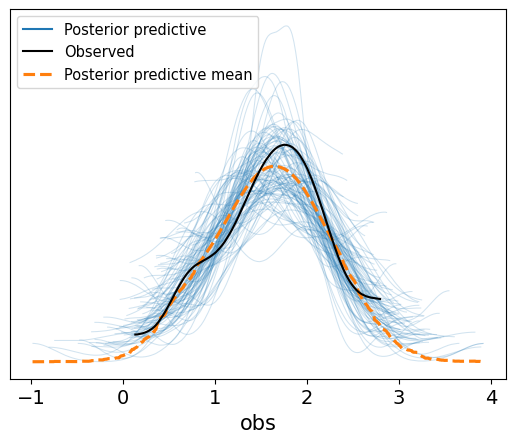

In [128]:
az.plot_ppc(idata, num_pp_samples=100);

In [129]:
ds = X.to_xarray()
X_xr = ds.to_array(dim='predictors')

In [71]:
post = idata.posterior
post.mean(("chain", "draw"))["b"]

<xarray.DataArray 'b' (predictors: 3)> Size: 24B
array([-0.21725682,  0.26268171,  0.16074062])
Coordinates:
  * predictors  (predictors) <U4 48B 'GSTM' 'IPO' 'AM'

In [130]:
mu_pp = post["a"] + post["b"] * X_xr

In [131]:
az.hdi(idata, hdi_prob=0.95)

<xarray.Dataset> Size: 176B
Dimensions:     (hdi: 2, predictors: 3)
Coordinates:
  * predictors  (predictors) <U4 48B 'GSTM' 'IPO' 'AM'
  * hdi         (hdi) <U6 48B 'lower' 'higher'
Data variables:
    a           (hdi) float64 16B 1.456 1.729
    b           (predictors, hdi) float64 48B -0.3508 -0.0762 ... 0.005734 0.317
    sigma       (hdi) float64 16B 0.4191 0.6247

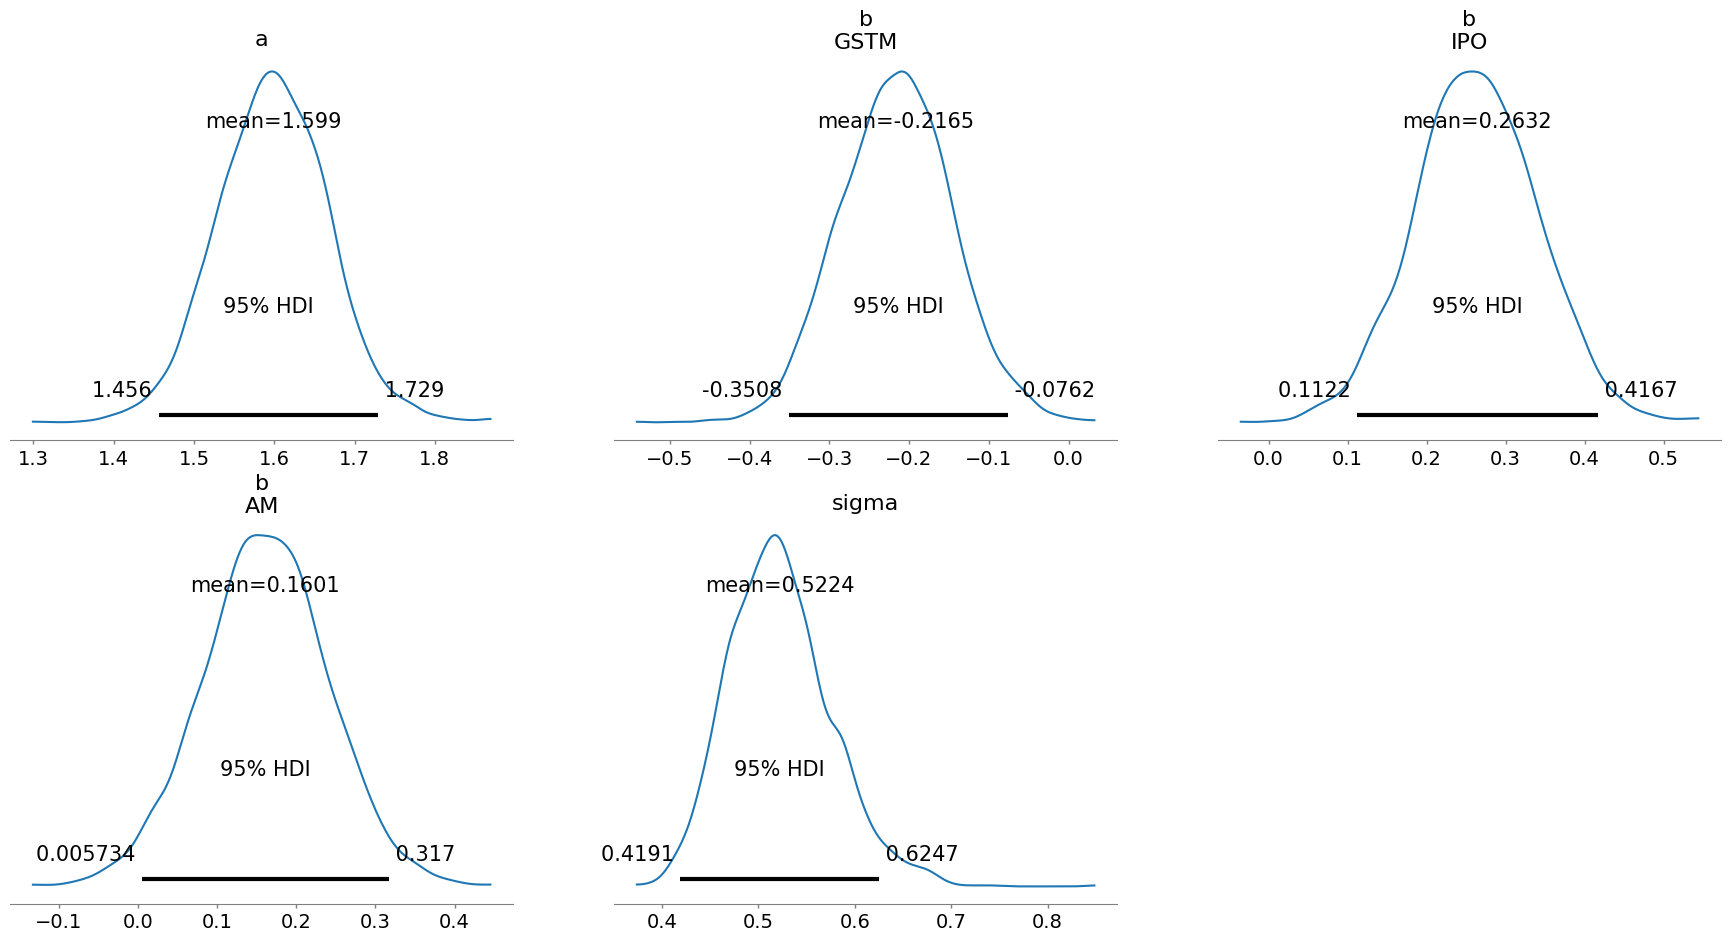

In [132]:
az.plot_posterior(idata, hdi_prob=0.95, var_names=["a","b","sigma"], round_to=4);

In [133]:
idata.posterior_predictive

<xarray.Dataset> Size: 2MB
Dimensions:    (chain: 4, draw: 1000, obs_dim_0: 56)
Coordinates:
  * chain      (chain) int64 32B 0 1 2 3
  * draw       (draw) int64 8kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * obs_dim_0  (obs_dim_0) int64 448B 0 1 2 3 4 5 6 7 ... 49 50 51 52 53 54 55
Data variables:
    obs        (chain, draw, obs_dim_0) float64 2MB 1.725 1.778 ... 1.004 1.649
Attributes:
    created_at:                 2025-05-15T17:07:45.550971+00:00
    arviz_version:              0.21.0
    inference_library:          pymc
    inference_library_version:  5.21.1

<Axes: >

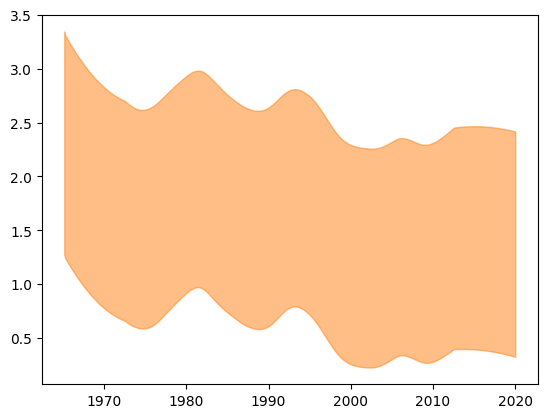

In [134]:
#ax.scatter(predictor_scaled, idata.observed_data["obs"])
az.plot_hdi(dat_no_na['year'], idata.posterior_predictive['obs'])

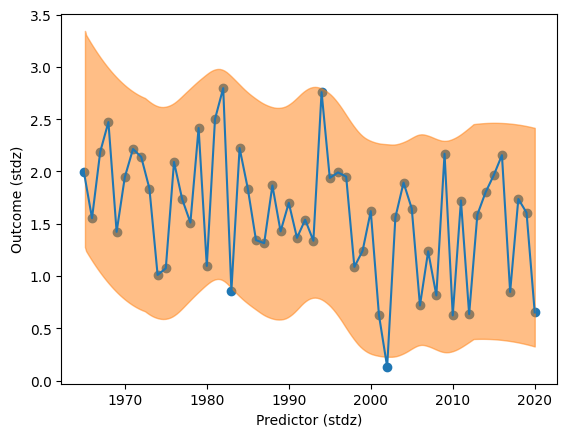

In [135]:
_, ax = plt.subplots()

#ax.plot(
#    da, mu_pp.mean(("chain", "draw")), label="Mean outcome", color="C1", alpha=0.6
#)
#ax.scatter(da, idata.observed_data["ll"])
ax.scatter(dat_no_na['year'], idata.observed_data["obs"])
ax.plot(dat_no_na['year'], idata.observed_data["obs"])
az.plot_hdi(dat_no_na['year'], idata.posterior_predictive['obs'])
ax.set_xlabel("Predictor (stdz)")
ax.set_ylabel("Outcome (stdz)");

<Axes: >

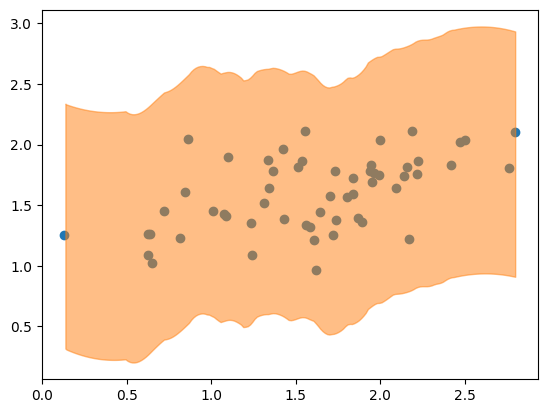

In [136]:
plt.scatter(y, idata.posterior_predictive['obs'].mean(("chain", "draw")))
az.plot_hdi(y, idata.posterior_predictive['obs'])


In [172]:
#Two approaches give same result

#1
y_fit = idata.posterior_predictive['obs'].mean(("chain", "draw")).values


#2
alpha = post.mean(("chain", "draw"))["a"].values
beta = post.mean(("chain", "draw"))["b"].values
y_fit = alpha + beta[0] * X.GSTM + beta[1] * X.IPO+ beta[2] * X.AM

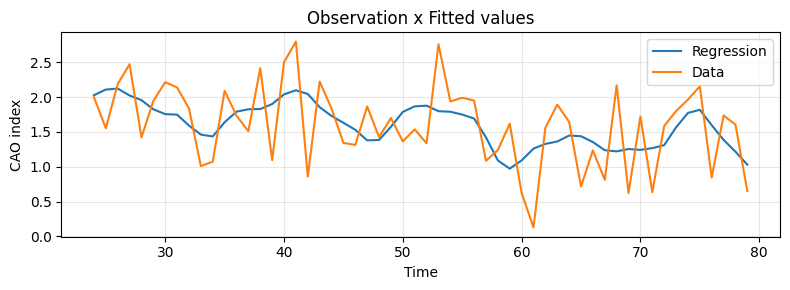

In [138]:
plt.figure(figsize=(8,3))
plt.plot(y_fit,label="Regression")
plt.plot(y,label="Data")
plt.title("Observation x Fitted values")
plt.ylabel("CAO index")
plt.xlabel("Time")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.legend()
plt.show()

In [142]:
_, vals = az.sel_utils.xarray_to_ndarray(idata["posterior"])

sigma = [azpu.calculate_point_estimate("median", val) for val in vals][4]

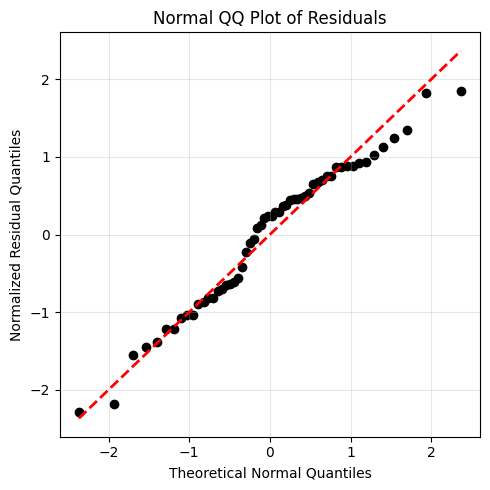

In [143]:
#QQ plot
residuals = y - y_fit  # Use residuals for QQ plot, not raw y values
sample_quantiles = np.sort(residuals)
n = len(sample_quantiles)
probs = (np.arange(1, n+1) - 0.5) / n
theoretical_quantiles = norm.ppf(probs, loc=0, scale=1)  # Standard normal quantiles

min_val = min(theoretical_quantiles.min(), (sample_quantiles/sigma).min())
max_val = max(theoretical_quantiles.max(), (sample_quantiles/sigma).max())

plt.figure(figsize=(5,5))
plt.scatter(theoretical_quantiles, sample_quantiles/sigma, color='black')
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
plt.title("Normal QQ Plot of Residuals")
plt.ylabel("Normalized Residual Quantiles")
plt.xlabel("Theoretical Normal Quantiles")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [162]:
idata.posterior["y_model"] = idata.posterior["a"] + idata.posterior["b"] * X_xr
idata.posterior["y_model"]

<xarray.DataArray 'y_model' (chain: 4, draw: 1000, predictors: 3, index: 56)> Size: 5MB
array([[[[1.86561567, 1.87200291, 1.86561567, ..., 1.23966584,
          1.23327859, 1.21411686],
         [1.57687804, 1.57107168, 1.55625578, ..., 1.64039254,
          1.49317177, 1.37288723],
         [1.72212201, 1.80154417, 1.83649444, ..., 1.72983205,
          1.69931368, 1.64287991]],

        [[1.92439875, 1.93023017, 1.92439875, ..., 1.35291956,
          1.34708814, 1.32959388],
         [1.66144389, 1.65641791, 1.64359328, ..., 1.71642199,
          1.58898781, 1.4848696 ],
         [1.83441724, 1.93172757, 1.97454965, ..., 1.84386381,
          1.80647181, 1.73732753]],

        [[1.67889528, 1.68423628, 1.67889528, ..., 1.15547728,
          1.15013628, 1.13411328],
         [1.43632405, 1.43099557, 1.41739907, ..., 1.49461106,
          1.35950711, 1.24912244],
         [1.54331077, 1.60029607, 1.62537285, ..., 1.54884271,
          1.52694582, 1.48645466]],
...
        [[1.88079724, 1.88673167, 1.88079724, ..., 1.2992239 ,
          1.29328948, 1.27548622],
         [1.60794049, 1.60062299, 1.58195118, ..., 1.68798493,
          1.50244927, 1.35086011],
         [1.65406609, 1.67139149, 1.67901565, ..., 1.65574798,
          1.64909061, 1.63677998]],

        [[2.11088454, 2.12073511, 2.11088454, ..., 1.14552946,
          1.1356789 , 1.10612721],
         [1.67776761, 1.67391671, 1.66409048, ..., 1.71989179,
          1.62225182, 1.54247653],
         [1.96721752, 2.13663271, 2.21118504, ..., 1.98366379,
          1.91856512, 1.79818641]],

        [[1.81698608, 1.82292809, 1.81698608, ..., 1.23466885,
          1.22872684, 1.2109008 ],
         [1.54652923, 1.54035414, 1.52459737, ..., 1.61407714,
          1.45750729, 1.32958421],
         [1.7761463 , 1.90603961, 1.96320006, ..., 1.78875591,
          1.73884374, 1.64654747]]]], shape=(4, 1000, 3, 56))
Coordinates:
  * chain       (chain) int64 32B 0 1 2 3
  * draw        (draw) int64 8kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * predictors  (predictors) <U4 48B 'GSTM' 'IPO' 'AM'
  * index       (index) int64 448B 24 25 26 27 28 29 30 ... 73 74 75 76 77 78 79

In [177]:
post = idata.posterior
y_fit = post["a"] + post["b"] * X_xr